## Pytorch with used cars

In [1]:
##################################################
### basic imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
### sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
### pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

Text(0, 0.5, 'price')

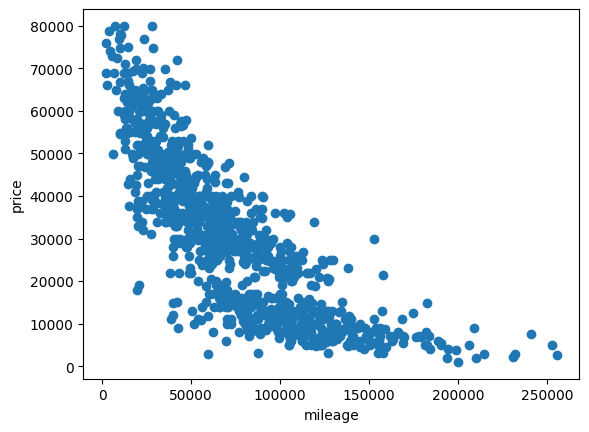

In [4]:
##################################################
### read in data and pull off x and y
dd = pd.read_csv("https://bitbucket.org/remcc/rob-data-sets/downloads/susedcars.csv")

y = dd['price'].to_numpy()
x = dd[['mileage','year']].to_numpy()

## look at data
plt.scatter(x[:,0],y)
plt.xlabel('mileage'); plt.ylabel('price')

In [5]:
##################################################
### train-test split

Xtr, Xte, Ytr, Yte = train_test_split(x,y,random_state=99, test_size=.2)

In [6]:
##################################################
## scale both x and y
sc = StandardScaler()
xtr = sc.fit_transform(Xtr)
xte = sc.transform(Xte)

scy = StandardScaler()
ytr = scy.fit_transform(Ytr.reshape(-1,1))
yte = scy.transform(Yte.reshape(-1,1))

Text(0.5, 0, 'standardized year')

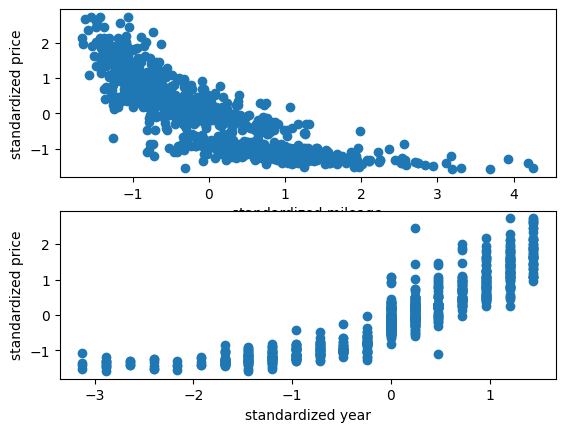

In [7]:
fig, ax = plt.subplots(2)
ax[0].scatter(xtr[:,0],ytr)
ax[1].scatter(xtr[:,1],ytr)
ax[0].set_ylabel('standardized price')
ax[1].set_ylabel('standardized price')
ax[0].set_xlabel('standardized mileage')
ax[1].set_xlabel('standardized year')

In [8]:
##################################################
## run a regression

lmmod = LinearRegression(fit_intercept=True)
lmmod.fit(xtr,ytr)
print("Model Slopes:    ",lmmod.coef_)
print("Model Intercept:",lmmod.intercept_)

yhat = lmmod.predict(xtr)

Model Slopes:     [[-0.34300427  0.6241386 ]]
Model Intercept: [1.22554284e-14]


Text(0, 0.5, 'y train')

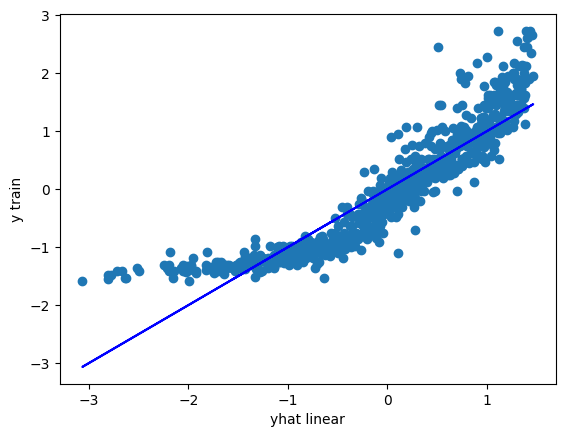

In [9]:
## train linear fit
plt.scatter(yhat,ytr)
plt.plot(yhat,yhat,c='blue')
plt.xlabel('yhat linear'); plt.ylabel('y train')

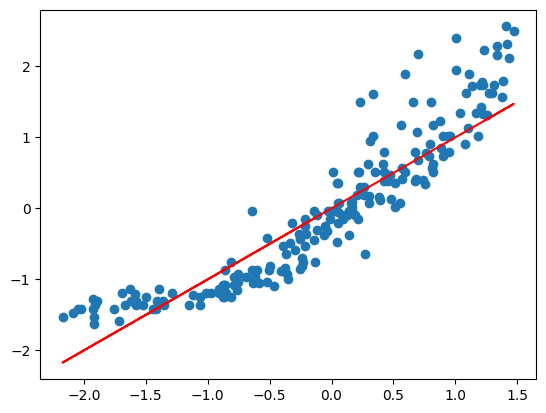

In [10]:
error = ytr-yhat
msee = (error*error).sum()/ytr.shape[0]
rmseLin = math.sqrt(msee)

## test linear fit
yhte = lmmod.predict(xte)

plt.scatter(yhte,yte)
plt.plot(yhte,yhte,c='red')

error = yte-yhte
msee = (error*error).sum()/yte.shape[0]
rmseLinTe = math.sqrt(msee)

torch.Size([800, 2])
torch.float32
torch.Size([800, 1])
torch.float32
torch.float32


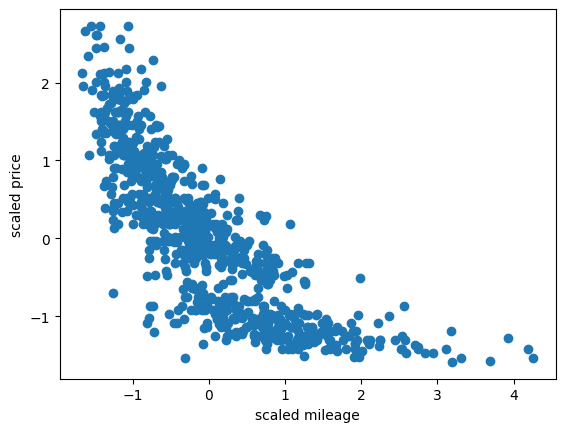

In [11]:
##################################################
## move to Tensors

xtr = xtr.astype('float32')
xxtr = torch.from_numpy(xtr)
ytr = ytr.astype('float32')
yytr = torch.from_numpy(ytr)

xte = xte.astype('float32')
xxte = torch.from_numpy(xte)
yte = yte.astype('float32')
yyte = torch.from_numpy(yte)

plt.scatter(xxtr[:,0],yytr)
plt.xlabel('scaled mileage'); plt.ylabel('scaled price')

print(xxtr.shape)
print(xxtr.dtype)
print(yytr.shape)
print(yytr.dtype)
print(yyte.dtype)

In [12]:
##################################################
## Dataset

class DF(Dataset):
   def __init__(self,x,y,transform=None, target_transform=None):
      self.x = x
      self.y = y
      self.transform = transform
      self.target_transform = target_transform

   def __len__(self):
      return len(self.y)

   def __getitem__(self,idx):
      return self.x[idx], self.y[idx]


tDF = DF(xxtr,yytr)

In [13]:
##################################################
## DataLoader
tdl = DataLoader(tDF,batch_size=50,shuffle=True)

In [14]:
##################################################
## model

class SLNN(nn.Module):
   def __init__(self,nunits=5):
      super(SLNN, self).__init__()
      self.SSM = nn.Sequential(
         nn.Linear(2,nunits),
         nn.Sigmoid(),
         nn.Linear(nunits,1))
   def forward(self,x):
      yhat = self.SSM(x)
      return yhat

nunits= 50
model = SLNN(nunits)

In [27]:
## see model
print(model)
## print out parameters
#for i, param in enumerate(model.parameters()):
#   print(f'******** {i}\n')
#   print(param)

SLNN(
  (SSM): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [16]:
##################################################
### do it
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_fn(model(dataloader.dataset.x),dataloader.dataset.y).item()



learning_rate = 1e-3
l2par = .005

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = l2par)

In [17]:
epochs = 5000
lv = np.zeros((epochs,))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lv[t] = train_loop(tdl, model, loss_fn, optimizer)
print("Done!")

Streaming output truncated to the last 5000 lines.
-------------------------------
Epoch 2502
-------------------------------
Epoch 2503
-------------------------------
Epoch 2504
-------------------------------
Epoch 2505
-------------------------------
Epoch 2506
-------------------------------
Epoch 2507
-------------------------------
Epoch 2508
-------------------------------
Epoch 2509
-------------------------------
Epoch 2510
-------------------------------
Epoch 2511
-------------------------------
Epoch 2512
-------------------------------
Epoch 2513
-------------------------------
Epoch 2514
-------------------------------
Epoch 2515
-------------------------------
Epoch 2516
-------------------------------
Epoch 2517
-------------------------------
Epoch 2518
-------------------------------
Epoch 2519
-------------------------------
Epoch 2520
-------------------------------
Epoch 2521
-------------------------------
Epoch 2522
-------------------------------
Epoch 2523
---

Text(0.5, 0, 'epoch')

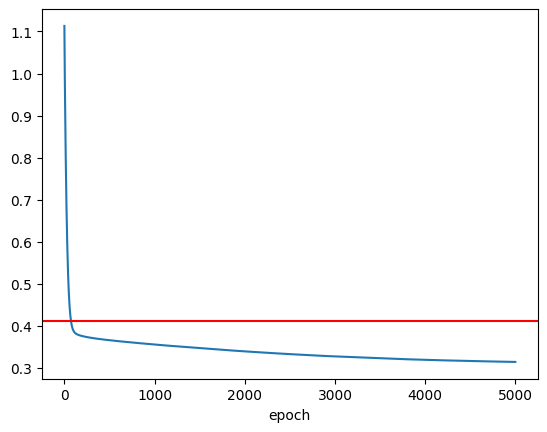

In [18]:
## plot loss over epochs
plt.plot(np.sqrt(lv))
plt.axhline(rmseLin,c='red')
plt.xlabel('epoch')

Text(0.5, 1.0, 'fit from neural net with 50 units')

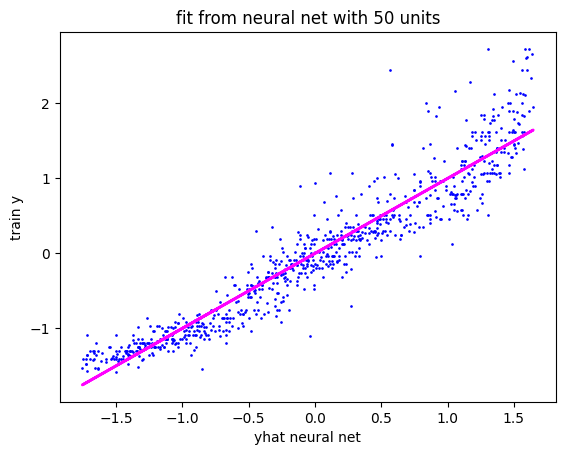

In [19]:
## plot fit
yyhat = model(xxtr).detach()
plt.scatter(yyhat,yytr,s=.85,c='blue')
#plt.scatter(yhat,yytr,s=.5,c='red')
plt.plot(yyhat,yyhat,c='magenta',linewidth=2)
plt.xlabel('yhat neural net'); plt.ylabel('train y')
tstr = 'fit from neural net with ' + str(nunits) + ' units'
plt.title(tstr)
#plt.legend(['y=x','neural net','linear'])

Text(0.5, 0, 'price')

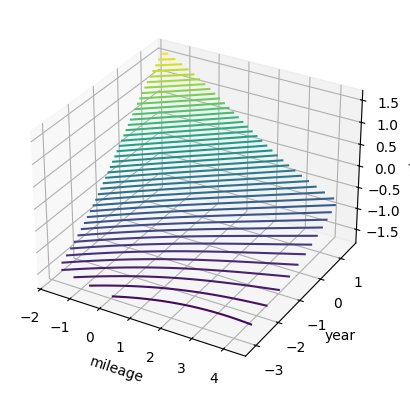

In [20]:
##################################################
## get fit on 2-way grid

ng=100
xg0 = np.linspace(xxtr[:,0].min(), xxtr[:,0].max(),ng)
xg1 = np.linspace(xxtr[:,1].min(), xxtr[:,1].max(),ng)

xx0, xx1 = np.meshgrid(xg0,xg1)

xg = np.hstack([xx0.reshape((ng*ng,1)),xx1.reshape((ng*ng,1))])
xg = xg.astype('float32')
xgT = torch.from_numpy(xg)

Yhatg = model(xgT).detach()
Yhatg2 = Yhatg.reshape((ng,ng))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(xx0,xx1,Yhatg2,50,cmap='viridis')
ax.set_xlabel('mileage')
ax.set_ylabel('year')
ax.set_zlabel('price')


******test rmse: Linear 0.436, NN 0.361



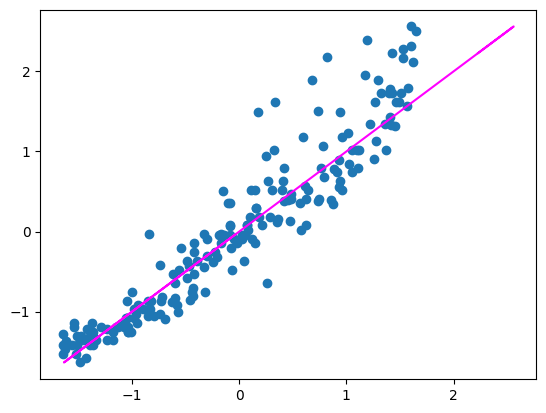

In [26]:
##################################################
### out of sample
yhatte = model(xxte).detach().numpy()

plt.scatter(yhatte,yyte)
plt.plot(yyte,yyte,c='magenta')


error = yyte.detach().numpy()  - yhatte
msee = (error*error).sum()/yte.shape[0]
rmseNnTe = math.sqrt(msee)

print(f'\n******test rmse: Linear {np.round(rmseLinTe,3)}, NN {np.round(rmseNnTe,3)}\n')

In [25]:
print(type(error))
ee = yyte.detach().numpy() - yhatte

<class 'torch.Tensor'>


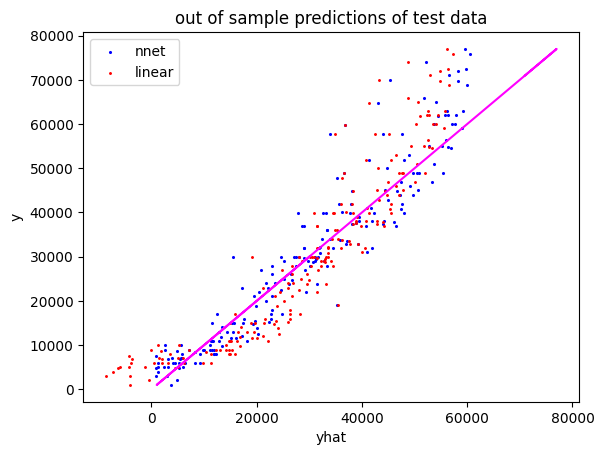

In [22]:
## original scale
yhatteO = scy.inverse_transform(yhatte)
yhatteL = lmmod.predict(xte)
yhatteLO = scy.inverse_transform(yhatteL)

plt.scatter(yhatteO,Yte,c='blue',s=1.5,label='nnet')
plt.scatter(yhatteLO,Yte,c='red',s=1.2,label='linear')
plt.title('out of sample predictions of test data')
plt.xlabel('yhat'); plt.ylabel('y')
plt.plot(Yte,Yte,c='magenta')
plt.legend()